In [1]:
import pandas as pd  # requires: pip install pandas
from chronos import BaseChronosPipeline
from mizani.breaks import minor_breaks, breaks_date
from mizani.formatters import date_format
from mizani.formatters import comma_format
import random
import numpy as np
import torch
import plotnine as p9
from blp import blp

In [3]:
# bquery = blp.BlpQuery().start()
# data =bquery.bdh(
#     ["EURUSD Curncy"],
#     ["PX_LAST"],
#     start_date="20100101",
#     end_date="20241229"
# )
#data.to_parquet('eurusd.parquet')
data = pd.read_parquet('eurusd.parquet')
df2 = data.copy()
df2 = df2.drop('security', axis=1)

pre24 = df2.query("date<'2024-01-01'").reset_index(drop=True)
post24 = df2.query("date>='2024-01-01'").reset_index(drop=True)
datum = post24['date'].to_list()

In [11]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

pipeline.model.eval()

final = df2.copy()
final['source'] = 'original'
laenge = 10 # wieviele Tage in die Zukunft prognostizieren
for item in datum:
    resource = df2.query("date<=@item").reset_index(drop=True)
    dates = df2.query("date>=@item").reset_index(drop=True)
    dates = dates.head(laenge)['date']

    context = torch.tensor(resource["PX_LAST"])
    quantiles, mean = pipeline.predict_quantiles(
        context=context,
        prediction_length=laenge,
        quantile_levels=[0.1, 0.5, 0.9],
    )
    result = pd.DataFrame(mean.numpy()).T.rename(columns={0:'PX_LAST'})
    result =pd.concat([result, dates], axis=1)
    result['source'] = str(item.date())
    final = pd.concat([final, result])

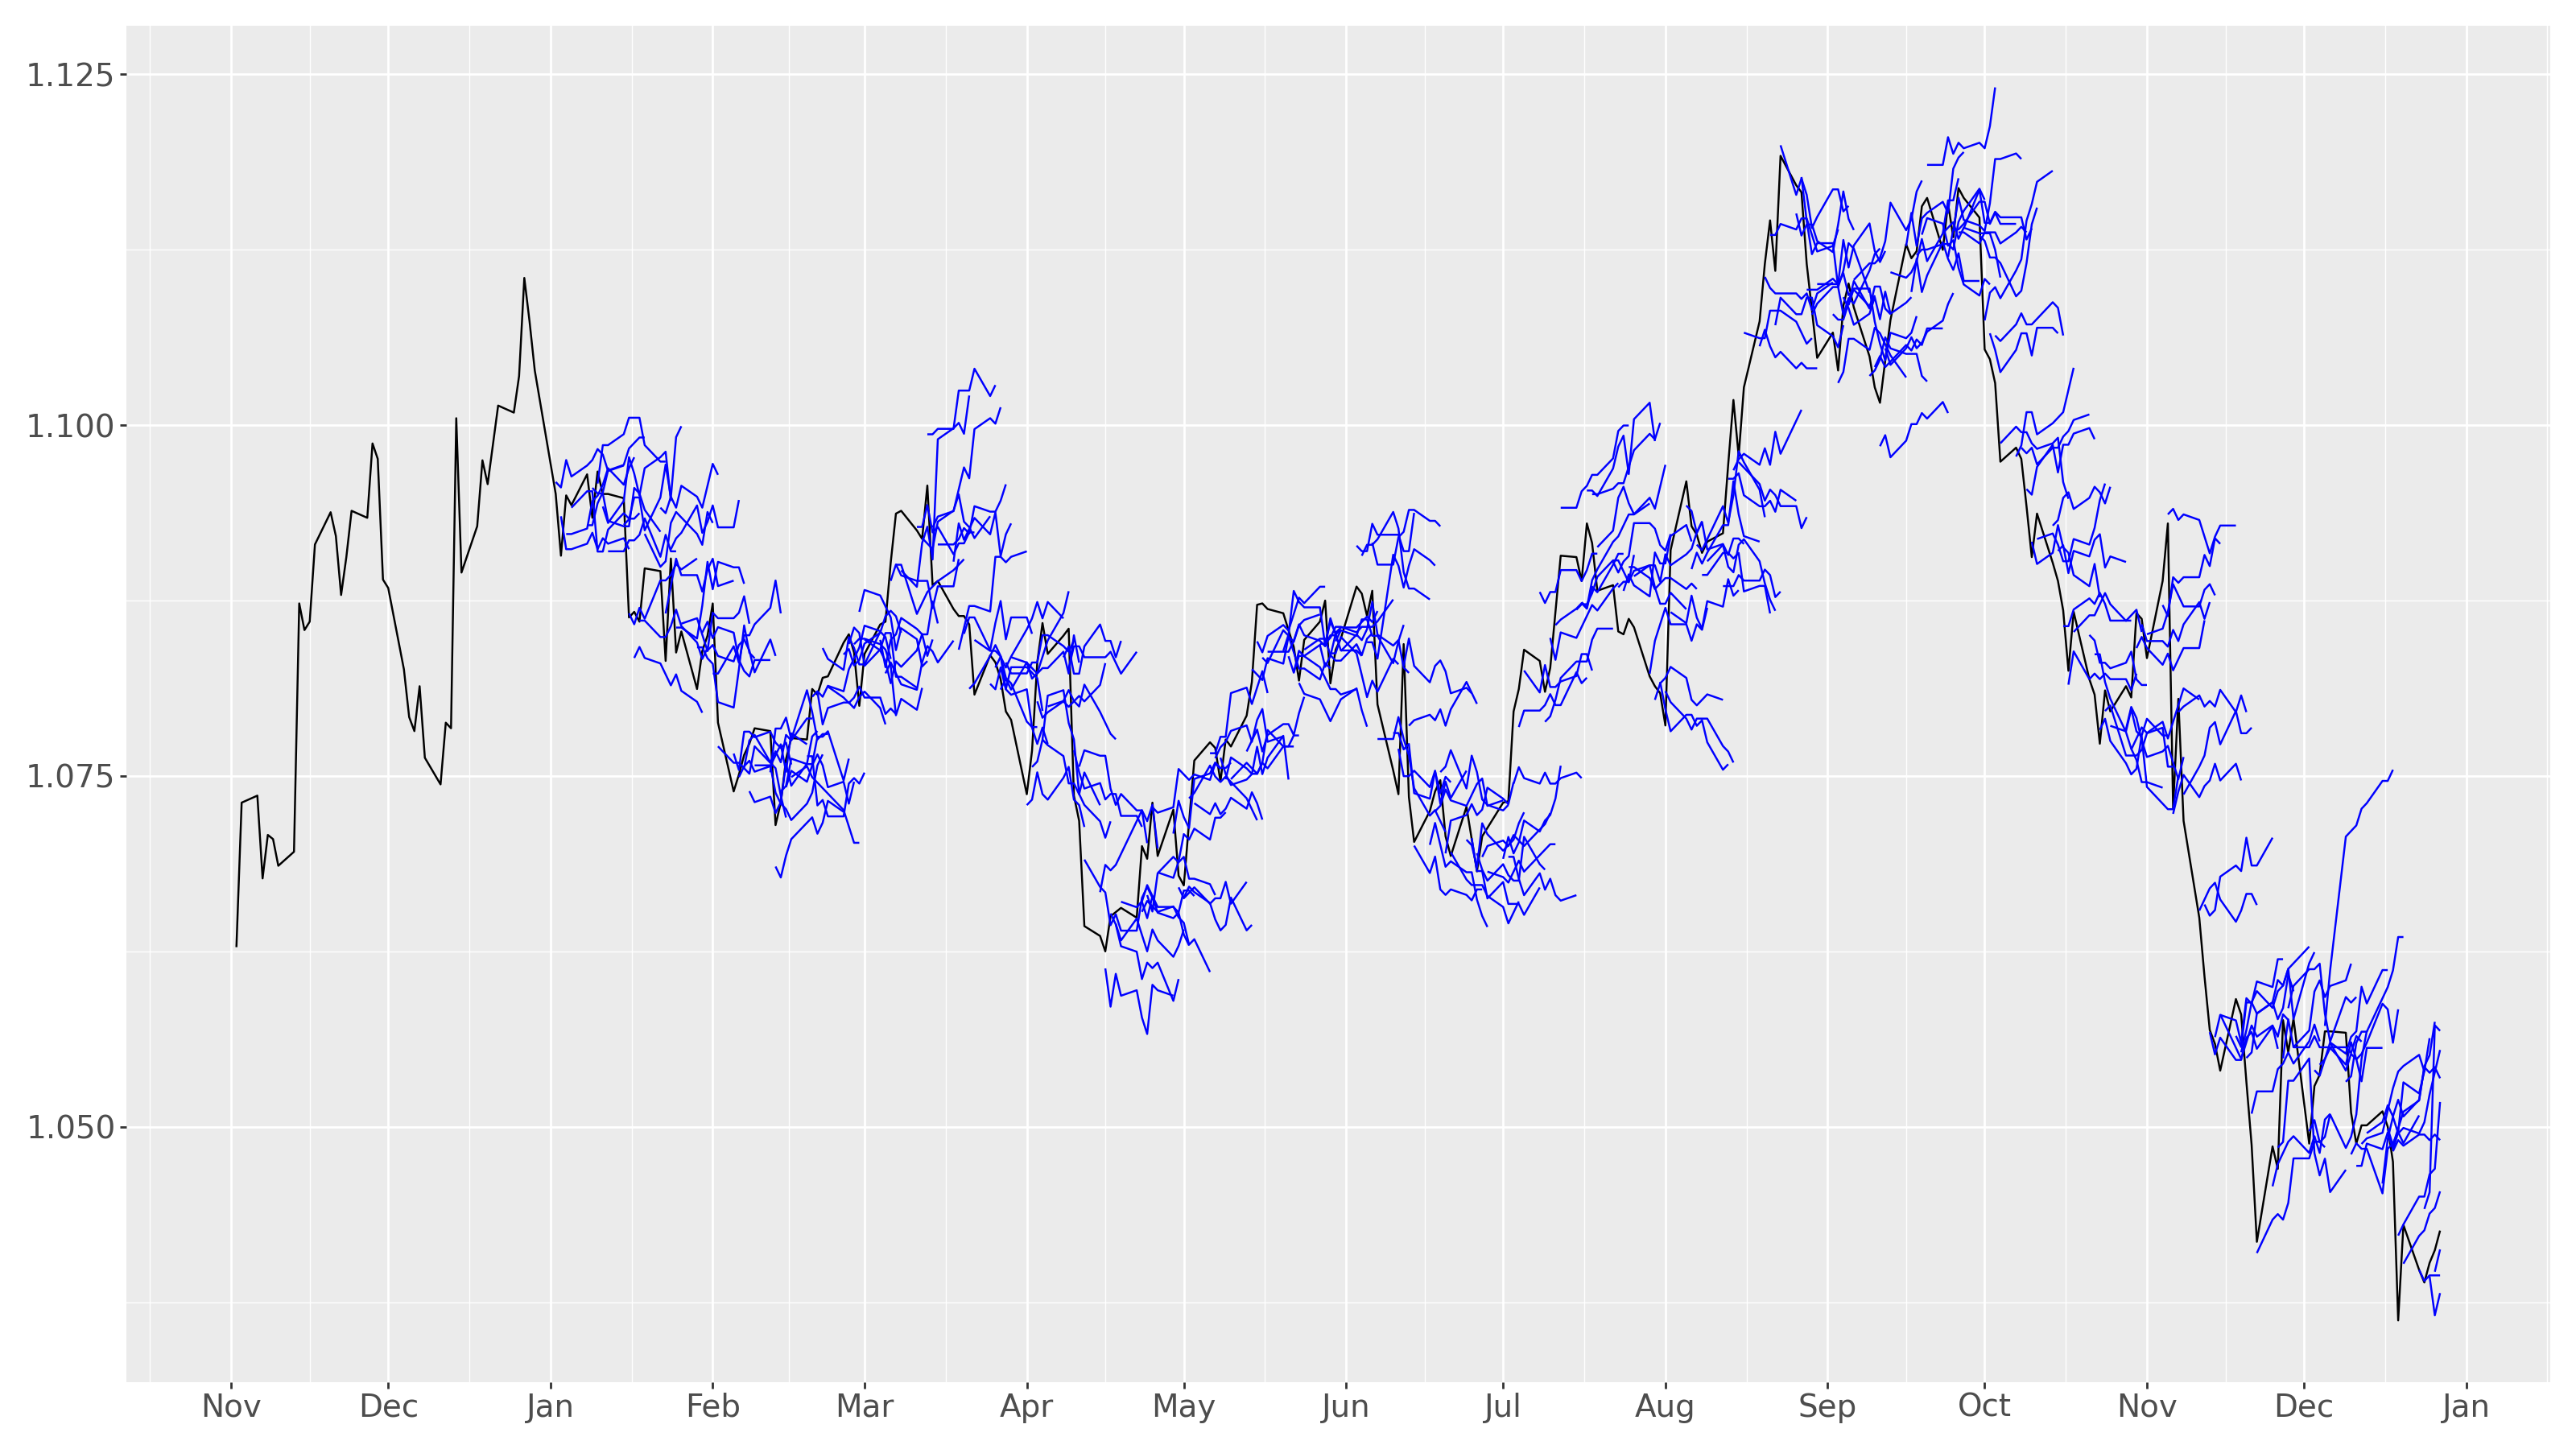

In [12]:
show = final.query("date>'2023-11-01'").reset_index(drop=True)
base = show.query("source=='original'").reset_index(drop=True)
prediction = show.query("source!='original'").reset_index(drop=True)

(p9.ggplot()
 + p9.scale_x_date(breaks=breaks_date(width='1 month'), labels=date_format('%b'))
 + p9.geom_line(p9.aes(x='date',y='PX_LAST', group='source'), data=base, color='black')
 + p9.geom_line(p9.aes(x='date',y='PX_LAST', group='source'), color='blue', data=prediction)
 + p9.theme(figure_size=[16,9])
 + p9.theme(legend_position='none')
 +p9.labs(x='',y='')
 +p9.theme(axis_text=p9.element_text(size=14))
 
 )